# Demo MODIS snow presence over Mt. Rainier, WA

### Installs and imports

In [1]:
#!pip install -q -e 'git+https://github.com/egagli/easysnowdata.git#egg=easysnowdata'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import xarray as xr
import easysnowdata
import modis_masking
#import dask_gateway

### Use dask gateway on planetary computer, we've got lots of computations to do...

In [3]:
# cluster = dask_gateway.GatewayCluster()
# client = cluster.get_client()
# client.upload_file('modis_masking.py')
# cluster.scale(50)
# print(cluster.dashboard_link)

### Use easysnowdata to check out some Sentinel-2 visual imagery of our AOI.

In [4]:
bbox_gdf = gpd.read_file(
    "https://github.com/egagli/easysnowdata/raw/main/docs/examples/mt_rainier.geojson"
)

In [5]:
s2 = easysnowdata.remote_sensing.Sentinel2(bbox_gdf,start_date='2022-07-10', end_date='2022-07-12')
s2.get_rgb()

Data searched. Access the returned seach with the .search attribute.
Data retrieved. Access with the .data attribute. Data CRS: WGS 84 / UTM zone 10N.
Nodata values removed from the data. In doing so, all bands converted to float32. To turn this behavior off, set remove_nodata=False.
Data acquired after January 25th, 2022 harmonized to old baseline. To turn this behavior off, set harmonize_to_old=False.
Data scaled to reflectance. To turn this behavior off, set scale_data=False.
Metadata retrieved. Access with the .metadata attribute.
RGB data retrieved. Access with the .rgb attribute, or .rgb_norm for normalized RGB.


Text(0.5, 1.0, 'July 11, 2022\n11:59AM')

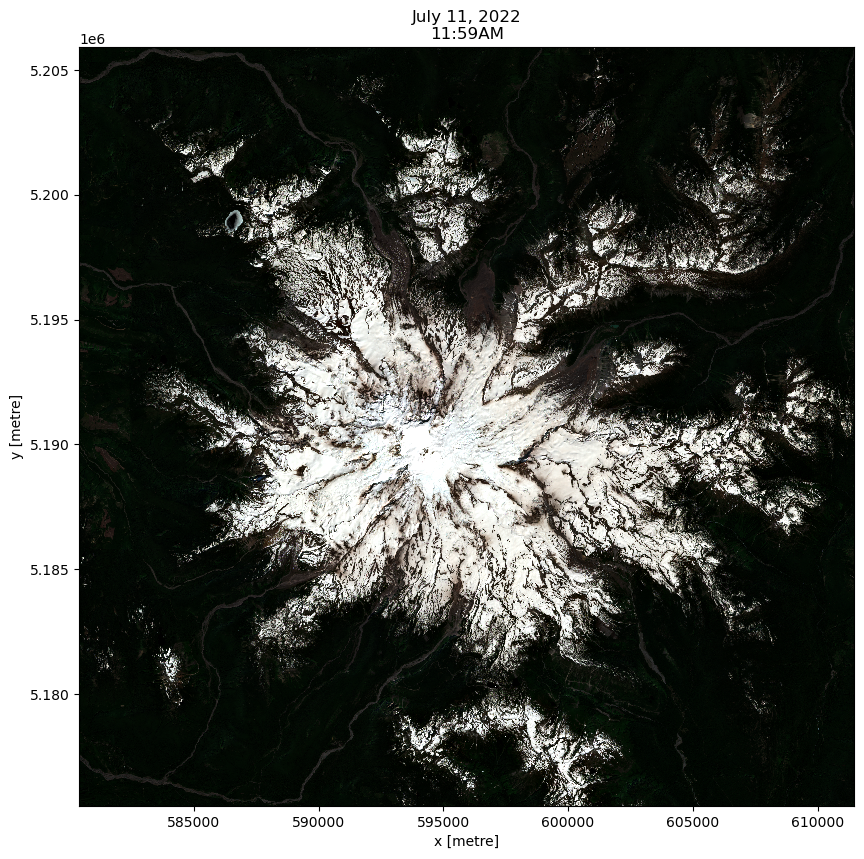

In [6]:
f,ax=plt.subplots(figsize=(10,10))
s2.rgb.plot.imshow(robust=True)
ax.set_aspect('equal')
local_time = pd.to_datetime(s2.rgb.time.values).tz_localize('UTC').tz_convert('America/Los_Angeles')
ax.set_title(f'{local_time.strftime("%B %d, %Y")}\n{local_time.strftime("%I:%M%p")}')

### Use easysnowdata to bring in MODIS MOD10A2 product, select 'Maximum_Snow_Extent'. Add WY and DOWY info to the time dimension.

In [7]:
WY_start = 2015
WY_end = 2023
modis_snow_da = easysnowdata.remote_sensing.MODIS_snow(bbox_gdf,clip_to_bbox=True,start_date=f'{WY_start-1}-10-01',end_date=f'{WY_end}-09-30',data_product="MOD10A2", bands='Maximum_Snow_Extent').data['Maximum_Snow_Extent']

Data retrieved. Access with the .data attribute.


In [23]:
hemisphere='northern'
modis_snow_da.coords['WY'] = ("time",pd.to_datetime(modis_snow_da.time).map(lambda x: easysnowdata.utils.datetime_to_WY(x, hemisphere=hemisphere)))
modis_snow_da.coords['DOWY'] = ("time",pd.to_datetime(modis_snow_da.time).map(lambda x: easysnowdata.utils.datetime_to_DOWY(x, hemisphere=hemisphere)))

modis_snow_da = modis_snow_da[(modis_snow_da.WY >= WY_start) & (modis_snow_da.WY <= WY_end)]

In [24]:
modis_snow_da

<xarray.DataArray 'Maximum_Snow_Extent' (time: 412, y: 66, x: 167)> Size: 5MB
dask.array<getitem, shape=(412, 66, 167), dtype=uint8, chunksize=(1, 66, 167), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 528B 5.226e+06 5.225e+06 ... 5.196e+06 5.196e+06
  * x            (x) float64 1kB -9.294e+06 -9.294e+06 ... -9.218e+06 -9.217e+06
    spatial_ref  int32 4B 0
  * time         (time) datetime64[ns] 3kB 2014-10-08 2014-10-16 ... 2023-09-30
    WY           (time) int64 3kB 2015 2015 2015 2015 ... 2023 2023 2023 2023
    DOWY         (time) int64 3kB 8 16 24 32 40 48 ... 325 333 341 349 357 365

### What does a time series of MOD10A2 Maximum_Snow_Extent look like for water year 2022? Let's project to UTM 10N for consistency with our Sentinel-2 image above. Values of 25 are no snow, 50 are clouds, 200 are snow. For more values and info, check out the [MOD10A2 user guide](https://nsidc.org/sites/default/files/mod10a2-v006-userguide_1.pdf). 

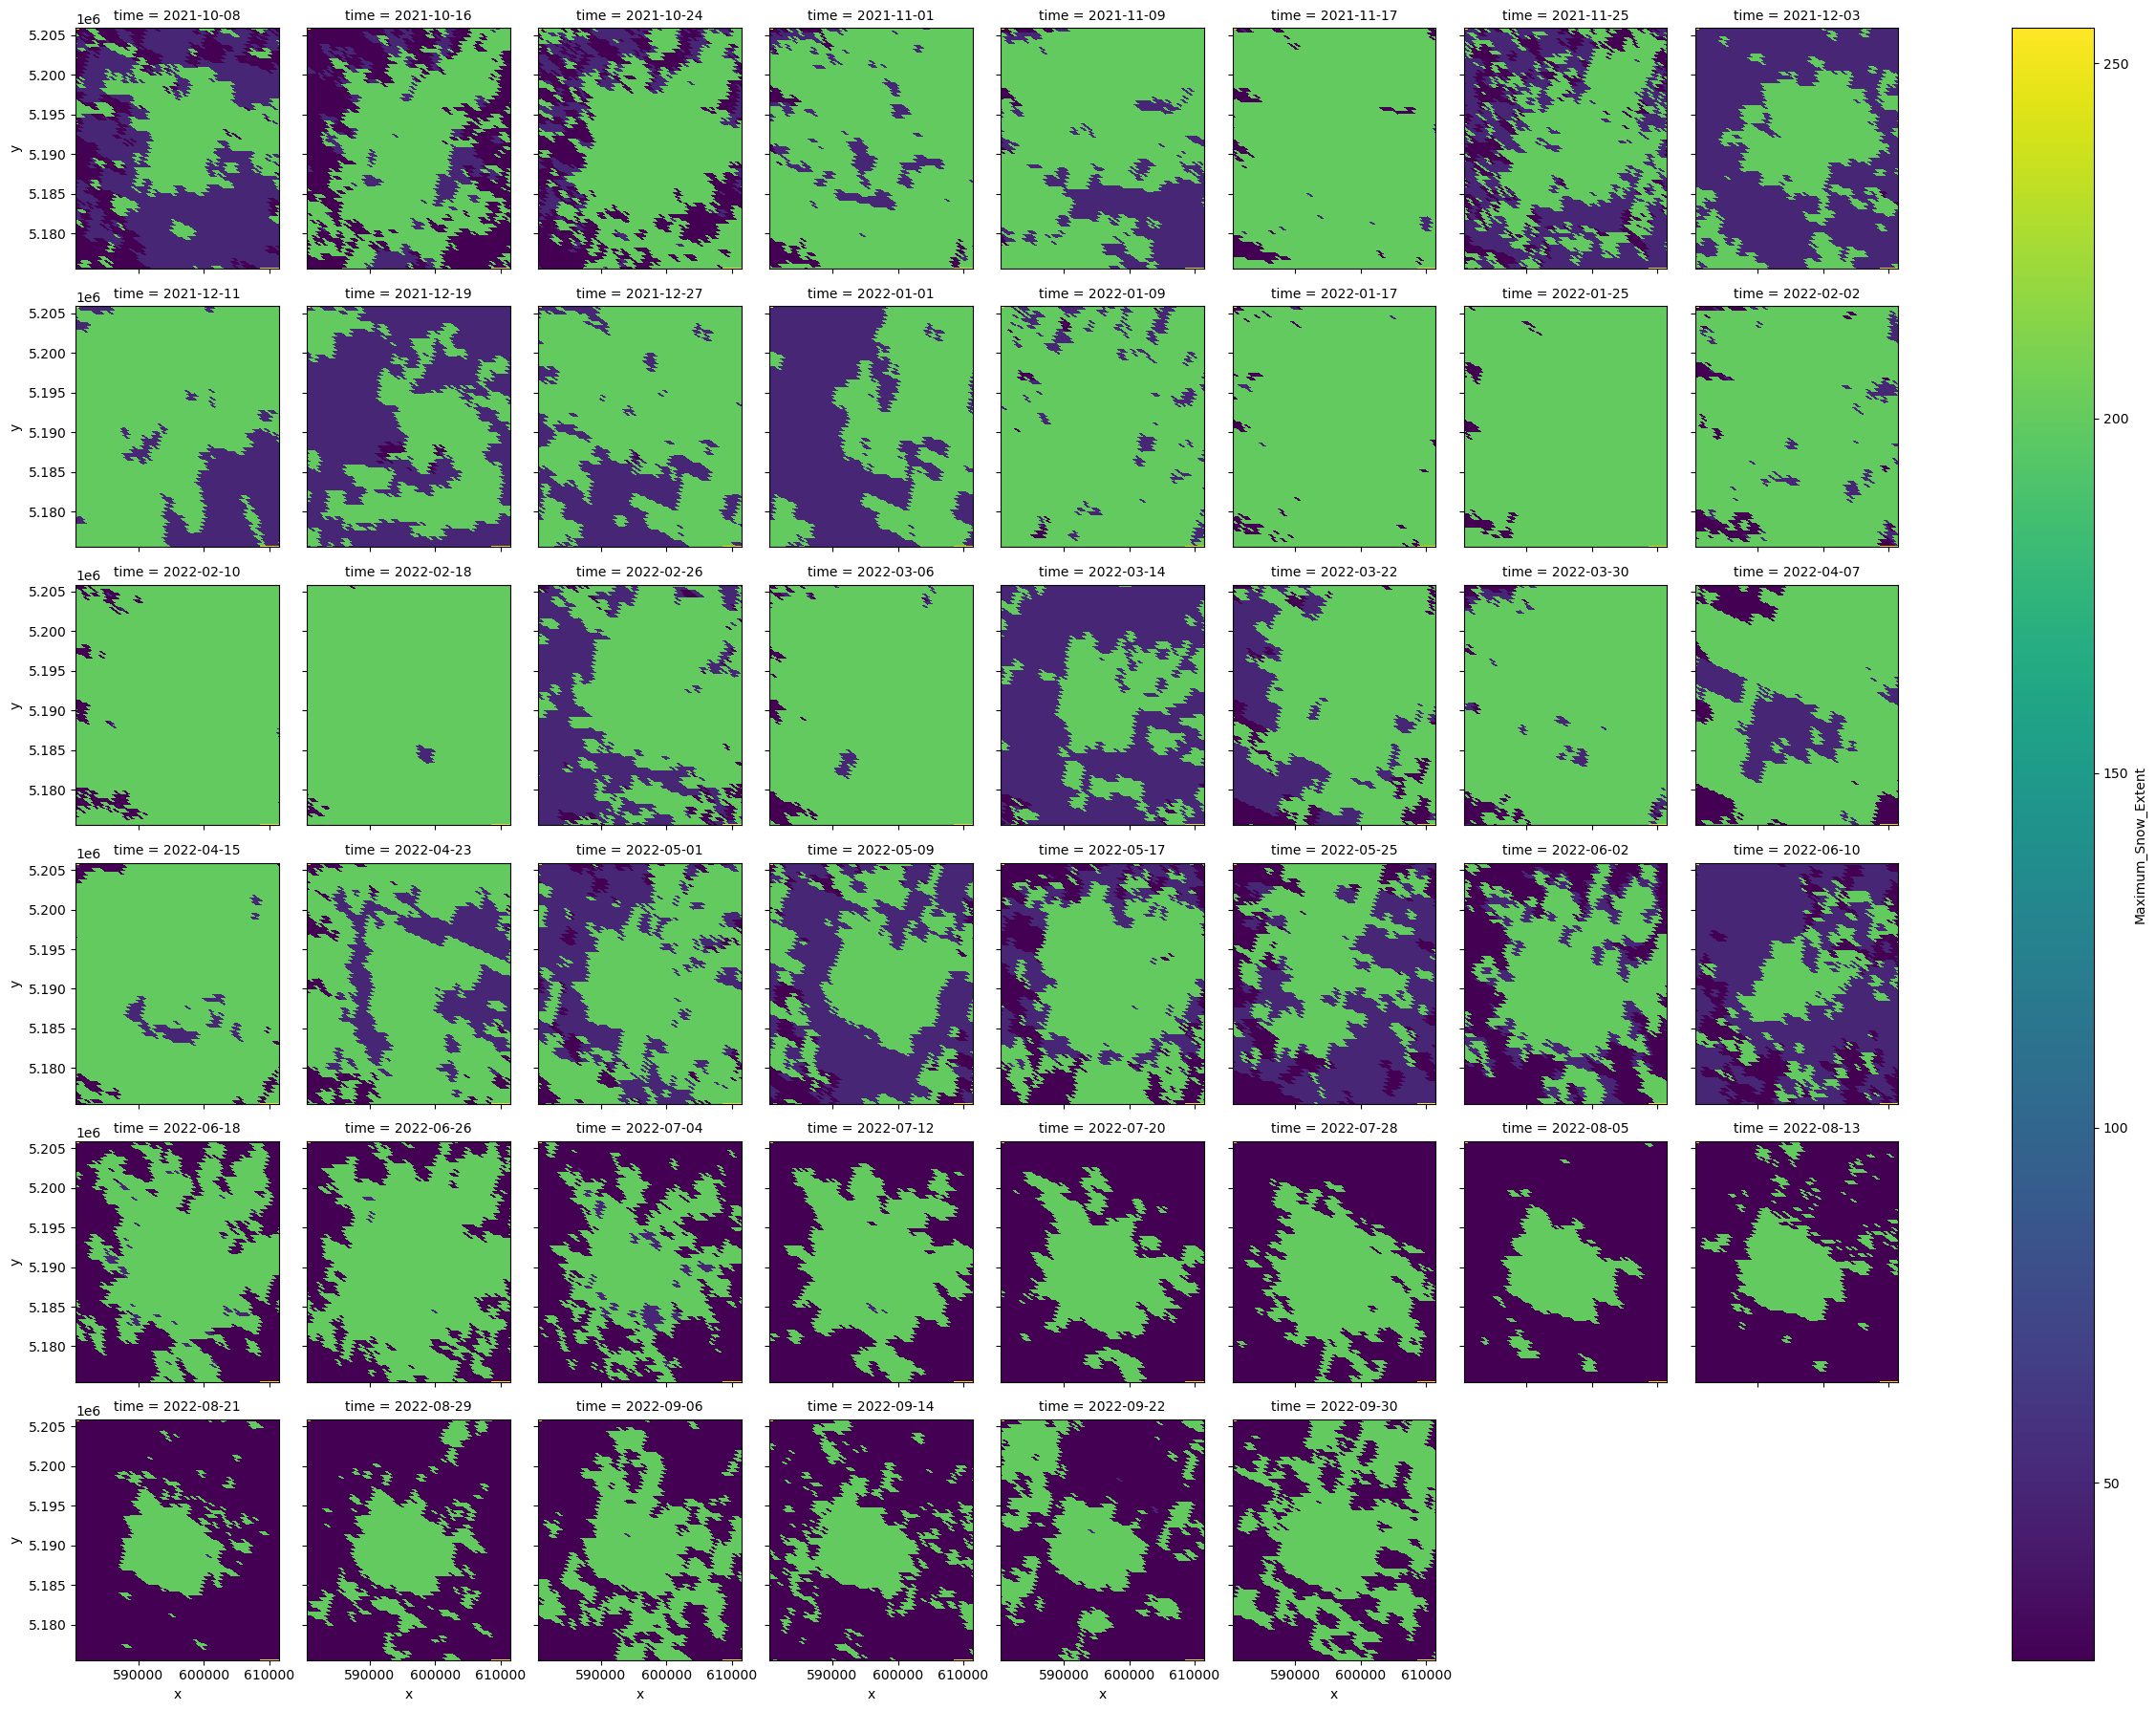

In [25]:
modis_snow_da[modis_snow_da['WY']==2022].rio.reproject_match(s2.rgb).plot.imshow(col='time',col_wrap=8)

### Now let's binarize and cloud fill the data.

In [26]:
effective_snow_da = modis_masking.binarize_with_cloud_filling(modis_snow_da)

In [27]:
effective_snow_da

<xarray.DataArray 'Maximum_Snow_Extent' (time: 412, y: 66, x: 167)> Size: 5MB
dask.array<rechunk-merge, shape=(412, 66, 167), dtype=bool, chunksize=(412, 66, 167), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 528B 5.226e+06 5.225e+06 ... 5.196e+06 5.196e+06
  * x            (x) float64 1kB -9.294e+06 -9.294e+06 ... -9.218e+06 -9.217e+06
    spatial_ref  int32 4B 0
  * time         (time) datetime64[ns] 3kB 2014-10-08 2014-10-16 ... 2023-09-30
    WY           (time) int64 3kB dask.array<chunksize=(412,), meta=np.ndarray>
    DOWY         (time) int64 3kB dask.array<chunksize=(412,), meta=np.ndarray>

### Create seasonal snow presence rasters with snow appearance date, snow disappearance date, and maximum number of consecutive snow days.

In [28]:
seasonal_snow_presence = effective_snow_da.groupby('WY').apply(modis_masking.get_max_consec_snow_days_SAD_SDD_one_WY).compute()

In [29]:
seasonal_snow_presence

<xarray.Dataset> Size: 597kB
Dimensions:               (WY: 9, y: 66, x: 167)
Coordinates:
  * y                     (y) float64 528B 5.226e+06 5.225e+06 ... 5.196e+06
  * x                     (x) float64 1kB -9.294e+06 -9.294e+06 ... -9.217e+06
    spatial_ref           int32 4B 0
  * WY                    (WY) int64 72B 2015 2016 2017 2018 ... 2021 2022 2023
Data variables:
    SAD_DOWY              (WY, y, x) int16 198kB 80 80 80 80 80 ... 64 40 32 40
    SDD_DOWY              (WY, y, x) int16 198kB 96 96 96 96 ... 189 197 197 197
    max_consec_snow_days  (WY, y, x) int16 198kB 16 16 16 16 ... 112 144 152 144

### Visualize the seasonal snow presence data for water year 2022.

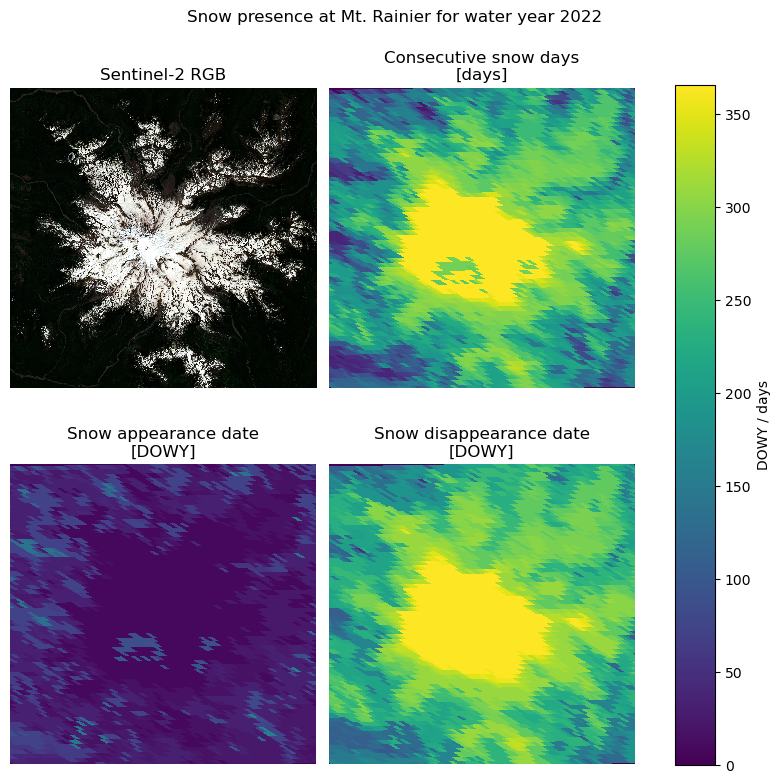

In [30]:
f,ax=plt.subplots(2,2,figsize=(8,8))

s2.rgb.plot.imshow(ax=ax[0,0],robust=True)
seasonal_snow_presence['max_consec_snow_days'].sel(WY=2022).rio.reproject_match(s2.rgb).plot(ax=ax[0,1],vmin=0,vmax=366,add_colorbar=False)
seasonal_snow_presence['SAD_DOWY'].sel(WY=2022).rio.reproject_match(s2.rgb).plot(ax=ax[1,0],vmin=0,vmax=366,add_colorbar=False)
cbar = seasonal_snow_presence['SDD_DOWY'].sel(WY=2022).rio.reproject_match(s2.rgb).plot(ax=ax[1,1],vmin=0,vmax=366,add_colorbar=False)

ax[0,0].set_title('Sentinel-2 RGB')
ax[0,1].set_title('Consecutive snow days\n[days]')
ax[1,0].set_title('Snow appearance date\n[DOWY]')
ax[1,1].set_title('Snow disappearance date\n[DOWY]')

for axs in ax.flatten():
    axs.set_aspect('equal')
    axs.axis('off')

f.suptitle('Snow presence at Mt. Rainier for water year 2022')
f.tight_layout()

f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.036, 0.05, 0.85])
f.colorbar(cbar, cax=cbar_ax,label='DOWY / days')

### Save as a zarr file and test we can open it again.

In [31]:
seasonal_snow_presence.to_zarr('output/demo/seasonal_snow_presence_rainier.zarr',mode='w')

In [32]:
seasonal_snow_presence_from_zarr = xr.open_zarr('output/demo/seasonal_snow_presence_rainier.zarr')

In [33]:
seasonal_snow_presence_from_zarr

<xarray.Dataset> Size: 597kB
Dimensions:               (WY: 9, y: 66, x: 167)
Coordinates:
  * WY                    (WY) int64 72B 2015 2016 2017 2018 ... 2021 2022 2023
    spatial_ref           int32 4B ...
  * x                     (x) float64 1kB -9.294e+06 -9.294e+06 ... -9.217e+06
  * y                     (y) float64 528B 5.226e+06 5.225e+06 ... 5.196e+06
Data variables:
    SAD_DOWY              (WY, y, x) int16 198kB dask.array<chunksize=(9, 66, 167), meta=np.ndarray>
    SDD_DOWY              (WY, y, x) int16 198kB dask.array<chunksize=(9, 66, 167), meta=np.ndarray>
    max_consec_snow_days  (WY, y, x) int16 198kB dask.array<chunksize=(9, 66, 167), meta=np.ndarray>

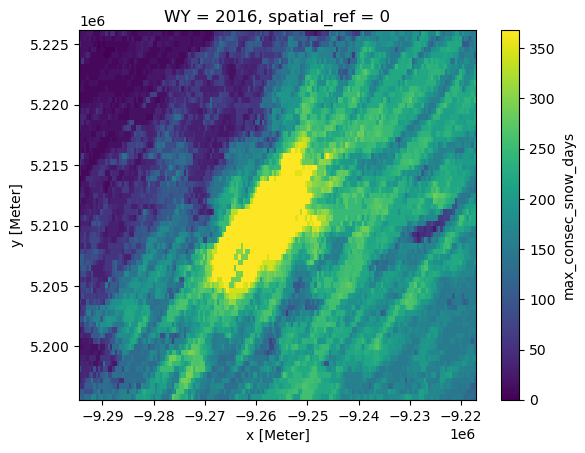

In [34]:
seasonal_snow_presence_from_zarr.sel(WY=2016)['max_consec_snow_days'].plot.imshow()

### That's it! Time to do some global processing...